In [167]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression 
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import ElasticNet


from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score

from scipy import stats

In [168]:
df = pd.read_csv('C:/Users/hugod/Downloads/Dados/NYC Ap/nyc-rolling-sales.csv')
df.head()

,Unnamed: 0,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BLOCK,LOT,EASE-MENT,BUILDING CLASS AT PRESENT,ADDRESS,...,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,SALE PRICE,SALE DATE
0,4,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2A,392,6,,C2,153 AVENUE B,...,5,0,5,1633,6440,1900,2,C2,6625000,2017-07-19 00:00:00
1,5,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,399,26,,C7,234 EAST 4TH STREET,...,28,3,31,4616,18690,1900,2,C7,-,2016-12-14 00:00:00
2,6,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,399,39,,C7,197 EAST 3RD STREET,...,16,1,17,2212,7803,1900,2,C7,-,2016-12-09 00:00:00
3,7,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2B,402,21,,C4,154 EAST 7TH STREET,...,10,0,10,2272,6794,1913,2,C4,3936272,2016-09-23 00:00:00
4,8,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2A,404,55,,C2,301 EAST 10TH STREET,...,6,0,6,2369,4615,1900,2,C2,8000000,2016-11-17 00:00:00


In [169]:
#Dropping columns that won't will help us to create our prediction model
del df['EASE-MENT']
del df['Unnamed: 0']
del df['SALE DATE']

In [170]:
#Checking for duplicated entries, avoiding add noise to the model
sum(df.duplicated(df.columns))

1358

In [171]:
#Checking again for duplicated entries, avoiding add noise to the model
df = df.drop_duplicates(df.columns, keep='last')
sum(df.duplicated(df.columns))

0

In [172]:
df.shape
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 83190 entries, 0 to 84547
Data columns (total 19 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   BOROUGH                         83190 non-null  int64 
 1   NEIGHBORHOOD                    83190 non-null  object
 2   BUILDING CLASS CATEGORY         83190 non-null  object
 3   TAX CLASS AT PRESENT            83190 non-null  object
 4   BLOCK                           83190 non-null  int64 
 5   LOT                             83190 non-null  int64 
 6   BUILDING CLASS AT PRESENT       83190 non-null  object
 7   ADDRESS                         83190 non-null  object
 8   APARTMENT NUMBER                83190 non-null  object
 9   ZIP CODE                        83190 non-null  int64 
 10  RESIDENTIAL UNITS               83190 non-null  int64 
 11  COMMERCIAL UNITS                83190 non-null  int64 
 12  TOTAL UNITS                     83190 non-null

In [173]:
df['BOROUGH'] = df['BOROUGH'].astype('category')
df['TAX CLASS AT TIME OF SALE'] = df['TAX CLASS AT TIME OF SALE'].astype('category')
df['TAX CLASS AT PRESENT'] = df['TAX CLASS AT PRESENT'].astype('category')

df['LAND SQUARE FEET'] = pd.to_numeric(df['LAND SQUARE FEET'], errors='coerce')
df['GROSS SQUARE FEET']= pd.to_numeric(df['GROSS SQUARE FEET'], errors='coerce')
df['SALE PRICE'] = pd.to_numeric(df['SALE PRICE'], errors='coerce')


KeyError: 'SALE DATE'

In [ ]:
df.columns[df.isnull().any()]

Index(['LAND SQUARE FEET', 'GROSS SQUARE FEET', 'SALE PRICE'], dtype='object')

In [ ]:
miss=df.isnull().sum()/len(df)
miss=miss[miss>0]
miss.sort_values(inplace=True)
miss

SALE PRICE           0.167196
LAND SQUARE FEET     0.312213
GROSS SQUARE FEET    0.327888
dtype: float64

In [ ]:
miss=miss.to_frame()
miss.columns=['count']
miss.index.names=['Name']
miss['Name']=miss.index
miss

,count,Name
Name,,
SALE PRICE,0.167196,SALE PRICE
LAND SQUARE FEET,0.312213,LAND SQUARE FEET
GROSS SQUARE FEET,0.327888,GROSS SQUARE FEET


<module 'seaborn' from 'C:\\Users\\hugod\\anaconda3\\lib\\site-packages\\seaborn\\__init__.py'>

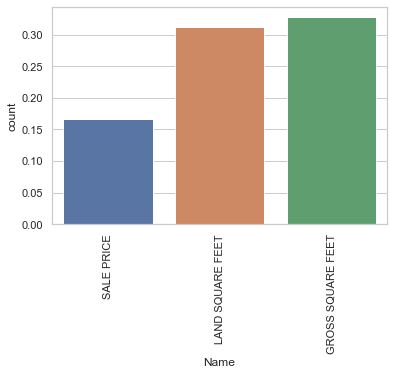

In [ ]:
#plot the missing values
sns.set(style='whitegrid',color_codes=True)
sns.barplot(x='Name', y='count',data=miss)
plt.xticks(rotation=90)
sns

In [ ]:
df['LAND SQUARE FEET']=df['LAND SQUARE FEET'].fillna(df['LAND SQUARE FEET'].mean())
df['GROSS SQUARE FEET']=df['GROSS SQUARE FEET'].fillna(df['GROSS SQUARE FEET'].mean())

In [ ]:
test=df[df['SALE PRICE'].isna()]
data=df[~df['SALE PRICE'].isna()]

In [ ]:
test = test.drop(columns='SALE PRICE')

In [ ]:
print(test.shape)
test.head()

(13909, 18)


,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BLOCK,LOT,BUILDING CLASS AT PRESENT,ADDRESS,APARTMENT NUMBER,ZIP CODE,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE
1,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,399,26,C7,234 EAST 4TH STREET,,10009,28,3,31,4616.0,18690.0,1900,2,C7
2,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,399,39,C7,197 EAST 3RD STREET,,10009,16,1,17,2212.0,7803.0,1900,2,C7
5,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,405,16,C4,516 EAST 12TH STREET,,10009,20,0,20,2581.0,9730.0,1900,2,C4
7,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,407,18,C7,520 EAST 14TH STREET,,10009,44,2,46,5163.0,21007.0,1900,2,C7
8,1,ALPHABET CITY,08 RENTALS - ELEVATOR APARTMENTS,2,379,34,D5,141 AVENUE D,,10009,15,0,15,1534.0,9198.0,1920,2,D5


In [ ]:
corr = data.corr()
corr['SALE PRICE'].sort_values(ascending=False)

SALE PRICE           1.000000
GROSS SQUARE FEET    0.449913
TOTAL UNITS          0.126654
RESIDENTIAL UNITS    0.122566
LAND SQUARE FEET     0.060143
COMMERCIAL UNITS     0.044535
LOT                  0.012266
YEAR BUILT          -0.003779
ZIP CODE            -0.034110
BLOCK               -0.061357
Name: SALE PRICE, dtype: float64

In [ ]:
numeric_data=data.select_dtypes(include=[np.number])
numeric_data.describe()

,BLOCK,LOT,ZIP CODE,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,SALE PRICE
count,69281.000000,69281.000000,69281.000000,69281.000000,69281.000000,69281.000000,6.928100e+04,6.928100e+04,69281.000000,6.928100e+04
mean,4200.305437,374.983473,10739.919458,1.870859,0.164244,2.055109,3.643061e+03,3.640300e+03,1800.113451,1.286521e+06
std,3434.828427,656.820333,1265.389144,14.317577,9.018311,17.026435,3.322172e+04,2.427118e+04,519.752668,1.145690e+07
min,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00
25%,1349.000000,21.000000,10306.000000,0.000000,0.000000,0.000000,1.900000e+03,1.268000e+03,1920.000000,2.350000e+05
50%,3377.000000,50.000000,11209.000000,1.000000,0.000000,1.000000,2.970000e+03,2.400000e+03,1938.000000,5.350000e+05
75%,6192.000000,879.000000,11249.000000,2.000000,0.000000,2.000000,3.858418e+03,3.891878e+03,1965.000000,9.500000e+05
max,16319.000000,9106.000000,11694.000000,1844.000000,2261.000000,2261.000000,4.252327e+06,3.750565e+06,2017.000000,2.210000e+09


<AxesSubplot:xlabel='SALE PRICE', ylabel='Density'>

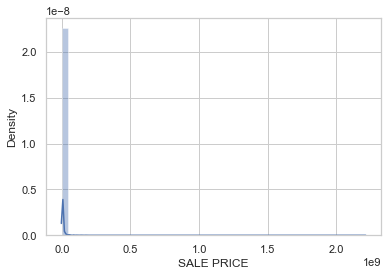

In [ ]:
sns.distplot(data['SALE PRICE'])

In [ ]:
data = data[(data['SALE PRICE'] > 100000) & (data['SALE PRICE'] < 5000000)]

<AxesSubplot:xlabel='SALE PRICE', ylabel='Density'>

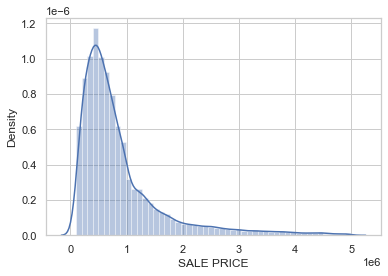

In [ ]:
sns.distplot(data['SALE PRICE'])

In [ ]:
data['SALE PRICE'].skew()


2.3437455096169386

0.19896303705046872


<AxesSubplot:xlabel='SALE PRICE', ylabel='Density'>

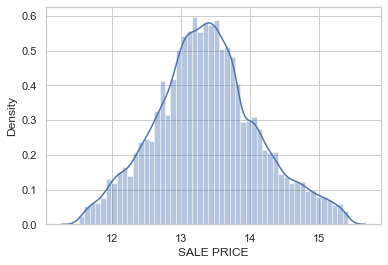

In [ ]:
#SALE PRICE is highly right skewed. So, we will log transform it so that it give better results.

sales=np.log(data['SALE PRICE'])
print(sales.skew())
sns.distplot(sales)

In [ ]:
data[["TOTAL UNITS", "SALE PRICE"]].groupby(['TOTAL UNITS'], as_index=False).count().sort_values(by='SALE PRICE', ascending=False)

,TOTAL UNITS,SALE PRICE
1,1,24886
0,0,15550
2,2,9576
3,3,2736
4,4,708
...,...,...
40,51,1
33,34,1
38,47,1
37,39,1


In [ ]:
#Removing rows with TOTAL UNITS == 0 and one outlier with 2261 units

data = data[(data['TOTAL UNITS'] > 0) & (data['TOTAL UNITS'] != 2261)] 

In [ ]:
cat_data=data.select_dtypes(exclude=[np.number])
cat_data.describe()

,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BUILDING CLASS AT PRESENT,ADDRESS,APARTMENT NUMBER,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE
count,39004,39004,39004,39004,39004,39004,39004,39004,39004
unique,5,248,38,9,117,31071,2643,3,117
top,4,FLUSHING-NORTH,01 ONE FAMILY DWELLINGS,1,R4,131-05 40TH ROAD,,1,R4
freq,12739,1677,12416,24245,8918,209,27038,25474,8922


In [ ]:
'''Data Pre Processing
Let's see our dataset again'''

del data['ADDRESS']
del data['APARTMENT NUMBER']

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39004 entries, 3 to 84545
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype   
---  ------                          --------------  -----   
 0   BOROUGH                         39004 non-null  category
 1   NEIGHBORHOOD                    39004 non-null  object  
 2   BUILDING CLASS CATEGORY         39004 non-null  object  
 3   TAX CLASS AT PRESENT            39004 non-null  category
 4   BLOCK                           39004 non-null  int64   
 5   LOT                             39004 non-null  int64   
 6   BUILDING CLASS AT PRESENT       39004 non-null  object  
 7   ZIP CODE                        39004 non-null  int64   
 8   RESIDENTIAL UNITS               39004 non-null  int64   
 9   COMMERCIAL UNITS                39004 non-null  int64   
 10  TOTAL UNITS                     39004 non-null  int64   
 11  LAND SQUARE FEET                39004 non-null  float64 
 12  GROSS SQUARE FEET 

In [ ]:
#transform the numeric features using log(x + 1)
from scipy.stats import skew
skewed = data[numeric_data.columns].apply(lambda x: skew(x.dropna().astype(float)))
skewed = skewed[skewed > 0.75]
skewed = skewed.index
data[skewed] = np.log1p(data[skewed])

In [ ]:
scaler = StandardScaler()
scaler.fit(data[numeric_data.columns])
scaled = scaler.transform(data[numeric_data.columns])

for i, col in enumerate(numeric_data.columns):
       data[col] = scaled[:,i]

data.head()

,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BLOCK,LOT,BUILDING CLASS AT PRESENT,ZIP CODE,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,SALE PRICE
3,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2B,-1.554798,-0.859725,C4,-1.433303,4.107235,-0.211188,4.200258,0.235594,0.787268,0.173754,2,C4,2.432819
6,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2B,-1.546973,-0.642582,C4,-1.433303,3.568687,-0.211188,3.636677,0.131654,0.594060,0.188489,2,C4,2.132408
76,1,ALPHABET CITY,12 CONDOS - WALKUP APARTMENTS,2,-1.586894,1.185890,R2,-1.433303,-0.467861,-0.211188,-0.587507,0.446496,0.560544,-3.853023,2,R2,-0.219736
79,1,ALPHABET CITY,13 CONDOS - ELEVATOR APARTMENTS,2,-1.613965,1.186424,R4,-1.433303,-0.467861,-0.211188,-0.587507,0.446496,0.560544,0.188489,2,R4,0.077491
80,1,ALPHABET CITY,13 CONDOS - ELEVATOR APARTMENTS,2,-1.613965,1.186957,R4,-1.433303,-0.467861,-0.211188,-0.587507,0.446496,0.560544,0.188489,2,R4,0.096524


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39004 entries, 3 to 84545
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype   
---  ------                          --------------  -----   
 0   BOROUGH                         39004 non-null  category
 1   NEIGHBORHOOD                    39004 non-null  object  
 2   BUILDING CLASS CATEGORY         39004 non-null  object  
 3   TAX CLASS AT PRESENT            39004 non-null  category
 4   BLOCK                           39004 non-null  float64 
 5   LOT                             39004 non-null  float64 
 6   BUILDING CLASS AT PRESENT       39004 non-null  object  
 7   ZIP CODE                        39004 non-null  float64 
 8   RESIDENTIAL UNITS               39004 non-null  float64 
 9   COMMERCIAL UNITS                39004 non-null  float64 
 10  TOTAL UNITS                     39004 non-null  float64 
 11  LAND SQUARE FEET                39004 non-null  float64 
 12  GROSS SQUARE FEET 

In [ ]:
del data['BUILDING CLASS AT PRESENT']
del data['BUILDING CLASS AT TIME OF SALE']
del data['NEIGHBORHOOD']

#Select the variables to be one-hot encoded
one_hot_features = ['BOROUGH', 'BUILDING CLASS CATEGORY','TAX CLASS AT PRESENT','TAX CLASS AT TIME OF SALE']

In [ ]:
# Convert categorical variables into dummy/indicator variables (i.e. one-hot encoding).
one_hot_encoded = pd.get_dummies(data[one_hot_features])
one_hot_encoded.info(verbose=True, memory_usage=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39004 entries, 3 to 84545
Data columns (total 58 columns):
 #   Column                                                                Non-Null Count  Dtype
---  ------                                                                --------------  -----
 0   BOROUGH_1                                                             39004 non-null  uint8
 1   BOROUGH_2                                                             39004 non-null  uint8
 2   BOROUGH_3                                                             39004 non-null  uint8
 3   BOROUGH_4                                                             39004 non-null  uint8
 4   BOROUGH_5                                                             39004 non-null  uint8
 5   BUILDING CLASS CATEGORY_01 ONE FAMILY DWELLINGS                       39004 non-null  uint8
 6   BUILDING CLASS CATEGORY_02 TWO FAMILY DWELLINGS                       39004 non-null  uint8
 7   BUILDING CLAS

In [ ]:
# Replacing categorical columns with dummies
fdf = data.drop(one_hot_features,axis=1)
fdf = pd.concat([fdf, one_hot_encoded] ,axis=1)
fdf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39004 entries, 3 to 84545
Data columns (total 68 columns):
 #   Column                                                                Non-Null Count  Dtype  
---  ------                                                                --------------  -----  
 0   BLOCK                                                                 39004 non-null  float64
 1   LOT                                                                   39004 non-null  float64
 2   ZIP CODE                                                              39004 non-null  float64
 3   RESIDENTIAL UNITS                                                     39004 non-null  float64
 4   COMMERCIAL UNITS                                                      39004 non-null  float64
 5   TOTAL UNITS                                                           39004 non-null  float64
 6   LAND SQUARE FEET                                                      39004 non-null  float64


In [ ]:
fdf.describe()

,BLOCK,LOT,ZIP CODE,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,SALE PRICE,...,TAX CLASS AT PRESENT_2,TAX CLASS AT PRESENT_2A,TAX CLASS AT PRESENT_2B,TAX CLASS AT PRESENT_2C,TAX CLASS AT PRESENT_3,TAX CLASS AT PRESENT_4,TAX CLASS AT TIME OF SALE_1,TAX CLASS AT TIME OF SALE_2,TAX CLASS AT TIME OF SALE_3,TAX CLASS AT TIME OF SALE_4
count,3.900400e+04,3.900400e+04,3.900400e+04,3.900400e+04,3.900400e+04,3.900400e+04,3.900400e+04,3.900400e+04,3.900400e+04,3.900400e+04,...,39004.000000,39004.000000,39004.000000,39004.000000,39004.0,39004.000000,39004.000000,39004.000000,39004.0,39004.000000
mean,7.809601e-15,-1.317209e-14,7.560122e-15,-1.800308e-14,-7.978903e-15,4.306091e-15,-2.735572e-14,1.729280e-16,-2.055287e-14,6.726840e-15,...,0.250846,0.029920,0.007871,0.024536,0.0,0.033612,0.653113,0.313199,0.0,0.033689
std,1.000013e+00,1.000013e+00,1.000013e+00,1.000013e+00,1.000013e+00,1.000013e+00,1.000013e+00,1.000013e+00,1.000013e+00,1.000013e+00,...,0.433506,0.170369,0.088370,0.154708,0.0,0.180230,0.475986,0.463800,0.0,0.180429
min,-5.758427e+00,-2.143900e+00,-1.752064e+01,-2.328086e+00,-2.111884e-01,-5.875072e-01,-2.843333e+00,-2.804219e+00,-3.853023e+00,-2.828228e+00,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000
25%,-4.962865e-01,-7.117800e-01,-9.462951e-01,-4.678610e-01,-2.111884e-01,-5.875072e-01,1.763696e-01,1.081428e-01,1.884885e-01,-6.481199e-01,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000
50%,2.657318e-01,-2.962854e-01,5.034777e-01,-4.678610e-01,-2.111884e-01,-5.875072e-01,2.953714e-01,2.896745e-01,2.305876e-01,-7.038073e-02,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,1.000000,0.000000,0.0,0.000000
75%,6.839580e-01,1.199075e+00,7.381415e-01,6.203007e-01,-2.111884e-01,5.512369e-01,4.464957e-01,5.605445e-01,3.274155e-01,5.795578e-01,...,1.000000,0.000000,0.000000,0.000000,0.0,0.000000,1.000000,1.000000,0.0,0.000000
max,1.377567e+00,2.367322e+00,1.274975e+00,1.785425e+01,2.405923e+01,1.861958e+01,3.234687e+00,3.356955e+00,3.926691e-01,2.775207e+00,...,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,0.0,1.000000


In [ ]:
Y_fdf = fdf['SALE PRICE']
X_fdf = fdf.drop('SALE PRICE', axis=1)


X_fdf.shape , Y_fdf.shape

((39004, 67), (39004,))

In [ ]:
X_train ,X_test, Y_train , Y_test = train_test_split(X_fdf , Y_fdf , test_size = 0.3 , random_state =34)
# Training set
X_train.shape , Y_train.shape

((27302, 67), (27302,))

In [ ]:
#Modelling
# RMSE
def rmse(y_test,y_pred):
      return np.sqrt(mean_squared_error(y_test,y_pred))



In [ ]:
#Linear Regression
linreg = LinearRegression()
linreg.fit(X_train, Y_train)
Y_pred_lin = linreg.predict(X_test)
rmse(Y_test,Y_pred_lin)



149825578.8414456

In [ ]:
#Lasso Regression
alpha=0.00099
lasso_regr=Lasso(alpha=alpha,max_iter=50000)
lasso_regr.fit(X_train, Y_train)
Y_pred_lasso=lasso_regr.predict(X_test)
rmse(Y_test,Y_pred_lasso)


0.7790791587756591

In [ ]:

#Ridge Regression
ridge = Ridge(alpha=0.01, normalize=True)
ridge.fit(X_train, Y_train)
Y_pred_ridge = ridge.predict(X_test)
rmse(Y_test,Y_pred_ridge)



0.7729312730940144

In [ ]:
#RandomForest Regressor
rf_regr = RandomForestRegressor()
rf_regr.fit(X_train, Y_train)
Y_pred_rf = rf_regr.predict(X_test)
rmse(Y_test,Y_pred_rf)

0.5608189114520481

In [ ]:
r2_score(Y_test, Y_pred_lin)


-2.2628538728640144e+16

In [ ]:
r2_score(Y_test, Y_pred_lasso)


0.3881460691968547

In [ ]:
r2_score(Y_test, Y_pred_ridge)


0.39776451717731054

In [ ]:
r2_score(Y_test, Y_pred_rf)

0.6829484494995228